# Comparison of control methods

Quantitative and qualitative comparison of the different control methods, implemented in different languages, for the solar home test bench

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Import solarhome utility module

In [3]:
from pathlib import Path
p_utils = Path('../utils')
assert(p_utils.exists())

import sys
sys.path.append(str(p_utils))

import benchutils
from benchutils import load_data, load_results

## Load testcase data

In [4]:
params, data = load_data()
data.head(3)

,P_load_sp,P_sun_1k,c_grid
0.0,0.520,0.0,0.1
0.5,0.528,0.0,0.1
1.0,0.496,0.0,0.1


In [5]:
n = len(data)
ndays = n//48 # days
ndays

30

In [6]:
E_rated = params['E_rated'] # kWh
P_pvp = params['P_pvp'] # kW
E_rated, P_pvp

(8, 4)

In [7]:
P_load = data.P_load_sp
P_sun = data.P_sun_1k*P_pvp;

t = data.index
dt = t[1] - t[0]
td = t/24 #days

Demo plot of input data

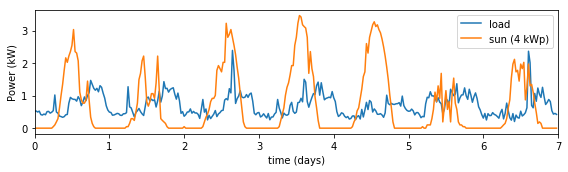

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,2.5))
z = slice(0, 7*48)
ax.plot(td[z], P_load.iloc[z], label='load')
ax.plot(td[z], P_sun.iloc[z], label='sun ({} kWp)'.format(P_pvp))
ax.legend()

ax.set(
    xlim = (0,7),
    xlabel = 'time (days)',
    ylabel = 'Power (kW)'   
)
fig.tight_layout()
fig.savefig('data_week_2011-11-29.pdf', bbox_inches='tight')

## Load results

### Matlab rule-base control

In [9]:
meta, stats, traj = load_results('../methods/matlab_rule-based/results', 'rule-based')

In [10]:
meta

{'E_rated': 8, 'P_pvp': 4, 'control method': 'rule-based'}

In [11]:
benchutils.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.94 kWh/d
P_pv:      13.66 kWh/d

P_sto:     0.025 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.282 €/d



In [12]:
traj.head(3)

,E_sto,P_sto,P_load_sp,P_shed,P_load,P_sun,P_curt,P_pv,P_grid,c_grid
0.0,4.000,-0.520,0.520,0,0.520,0.0,0.0,0.0,0.0,0.1
0.5,3.740,-0.528,0.528,0,0.528,0.0,0.0,0.0,0.0,0.1
1.0,3.476,-0.496,0.496,0,0.496,0.0,0.0,0.0,0.0,0.1


Plot routine

In [13]:
def plot_traj(meta, stats, traj):
    fig, ax = plt.subplots(2,1, sharex=True)
    
    dt = 0.5 # hours
    t = np.arange(len(traj))*dt
    td = t/24
    
    P_nl = traj.P_load_sp - traj.P_sun
    
    ax[0].plot(td, P_nl, label='load − sun',
               color=(0.5,)*3)
    #ax[0].plot(td, traj.P_sto, label='sto',
    #           color='tab:green', ls='-')
    ax[0].plot(td, traj.P_grid-traj.P_curt,label='grid − curt',
               color='tab:red')
    P_gc = traj.P_grid-traj.P_curt
    

    ax[0].fill_between(td, P_gc, where=P_gc>=0,
                       color='tab:red', alpha=0.25, lw=0)
    ax[0].fill_between(td, P_gc, where=P_gc<=0,
                       color=(1,1,0), alpha=0.25, lw=0)
    
    c_low = traj.c_grid<0.15
    y1, y2 = ax[0].get_ylim()
    ax[0].fill_between(td, y1, y2, where=c_low,
                   color=(0.9,0.95,1), lw=0, zorder=-10)
    
    ax[0].legend(ncol=4)
    ax[0].set(
        ylabel='Power (kW)',
        ylim=(y1, y2)
    )
    ax[0].grid(True)

    ax[1].plot(td, traj.E_sto, label='$E_{sto}$',
               color='tab:green');
    ax[1].axhline(0, color='tab:green', lw=0.5)
    ax[1].axhline(meta['E_rated'], color='tab:green', lw=0.5)

    ax[1].legend()
    ax[1].set(
        xlim=(td[0], td[-1]),
        xlabel='time (days)',
        ylabel='Energy (kWh)',
        ylim=(-.05*E_rated, 1.05*E_rated)
    )
    fig.tight_layout()
    return fig, ax

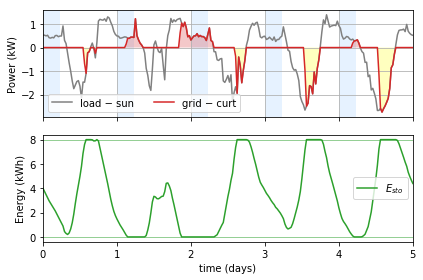

In [14]:
fig, ax = plot_traj(meta, stats, traj[0:24*5])
fig.savefig('matlab_rule-based.pdf', bbox_inches='tight')
fig.savefig('matlab_rule-based.png', bbox_inches='tight', dpi=150)

### Matlab MPC

two variants:

* with forecast equal to the average over the past same hours of the day
* perfect anticipative forecast

In [35]:
meta, stats, traj = load_results('../methods/matlab_mpc/results', 'Model predictive')

In [36]:
benchutils.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     2.94 kWh/d
P_pv:      12.66 kWh/d

P_sto:     0.025 kWh/d

P_grid:     4.38 kWh/d
C_grid:    0.272 €/d



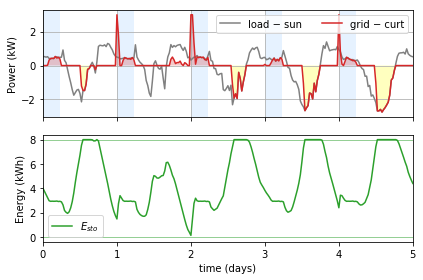

In [37]:
fig, ax = plot_traj(meta, stats, traj[0:24*5])
fig.savefig('matlab_mpc.pdf', bbox_inches='tight')
fig.savefig('matlab_mpc.png', bbox_inches='tight', dpi=150)

In [38]:
meta, stats, traj = load_results('../methods/matlab_mpc/results', 'Model predictive Perfect')

In [39]:
benchutils.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.94 kWh/d
P_pv:      13.66 kWh/d

P_sto:     0.025 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.177 €/d



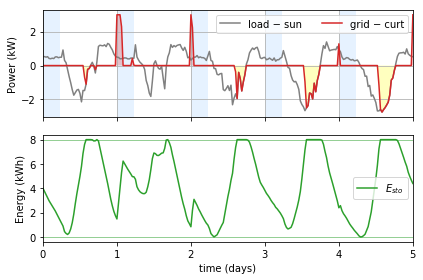

In [40]:
fig, ax = plot_traj(meta, stats, traj[0:24*5])
fig.savefig('matlab_mpc_anticip.pdf', bbox_inches='tight')
fig.savefig('matlab_mpc_anticip.png', bbox_inches='tight', dpi=150)

### Julia - JuMP

variants:

* anticipative: optimal control over the 30 days with real input data
* fixed: optimization over the 30 days using the forecast, and then run with true data, using P_grid and P_curt as recourses

In [41]:
meta, stats, traj = load_results('../methods/julia_jump_mpc/results', 'anticipative')

In [42]:
benchutils.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     1.97 kWh/d
P_pv:      13.64 kWh/d

P_sto:       0.0 kWh/d

P_grid:     3.38 kWh/d
C_grid:    0.177 €/d



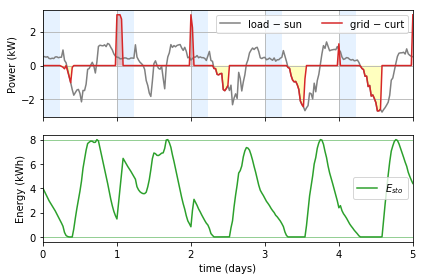

In [43]:
fig, ax = plot_traj(meta, stats, traj[0:24*5])
fig.savefig('julia_anticipative.pdf', bbox_inches='tight')
fig.savefig('julia_anticipative.png', bbox_inches='tight', dpi=150)

In [44]:
meta, stats, traj = load_results('../methods/julia_jump_mpc/results', 'fixed')

In [45]:
benchutils.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     5.32 kWh/d
P_pv:      10.28 kWh/d

P_sto:       0.0 kWh/d

P_grid:     6.74 kWh/d
C_grid:    0.508 €/d



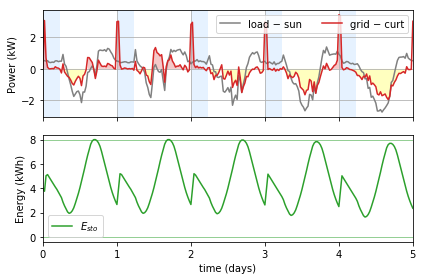

In [46]:
fig, ax = plot_traj(meta, stats, traj[0:24*5])
fig.savefig('julia_fixed.pdf', bbox_inches='tight')
fig.savefig('julia_fixed.png', bbox_inches='tight', dpi=150)